# Deep Learning Recommenders

In this notebook, we will look approaches to using Deep Learning to provide movie recommendations. At best, Deep Learning may do a little better than SVD. This is in contrast to other methods that we have seen like image recognition and text generation where deep learning has a huge edge over other architectures.

Let's see how deep learning does with the updated movie data.

# Load the data

This time we are going to use the updated movielens 100k recommender dataset via keras. It goes up to 2018 and is cleaner. Alternatively, you may download to your local computer here: https://grouplens.org/datasets/movielens/

In [48]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [49]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
movies_file = movielens_dir / "movies.csv"

df_ratings = pd.read_csv(ratings_file)
df_movies = pd.read_csv(movies_file)

In [50]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [51]:
df_movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


# Modify DataFrames

In [52]:
#Change the title to only a title
title=[]
for i in df_movies['title']:
    title.append(i.split(' (')[0])
df_movies['title']=title

In [53]:
# combine dataFrames into one
df = pd.merge(df_movies, df_ratings)
df = df[['userId', 'movieId','title', 'rating']]
df.head()

,userId,movieId,title,rating
0,1,1,Toy Story,4.0
1,5,1,Toy Story,4.0
2,7,1,Toy Story,4.5
3,15,1,Toy Story,2.5
4,17,1,Toy Story,4.5


## Create movie dictionary

In [54]:
def movie_title_id_dict(df, movie_title_col, movie_id_col, display=False):
  movie_dict = {}
  for i in range(len(df)):
    title = df.loc[i, movie_title_col]
    if title not in movie_dict:
      movie_dict[title] = df.loc[i, movie_id_col]
  if display:
    import operator
    for k,v in sorted(movie_dict.items(), key=operator.itemgetter(1))[:5]:
      print(f'{k}: {v}')
  return movie_dict

movie_dict = movie_title_id_dict(df_movies, 'title', 'movieId', display=True)

Toy Story: 1
Jumanji: 2
Grumpier Old Men: 3
Waiting to Exhale: 4
Father of the Bride Part II: 5


## Option: Add Yourself to DataFrame

In [55]:
 #1a. Create dictionary of movie titles and your rankings
 #1b. Loop through dictionary, add yourself as user 0 with movies + rankings
 # df.loc[index] = [0, 'Godfather, The', 5] adds new row if index unused
my_movies = {'Godfather, The':4,
             'Matrix, The':2,
             "Harry Potter and the Sorcerer's Stone":5,
             'Suicide Squad':1,
             'Ex Machina':5,
             'Clockwork Orange, A':3,
             'Back to the Future':5,
             "Ferris Bueller's Day Off":5,
             'Monty Python and the Holy Grail':4,
             'Princess Bride, The':4,
             'Toy Story':2}
index = len(df)
for movie in my_movies:
  df.loc[index] = [0, movie_dict[movie], movie, my_movies[movie]]
  index += 1
df.tail()

,userId,movieId,title,rating
100842,0,1270,Back to the Future,5.0
100843,0,2918,Ferris Bueller's Day Off,5.0
100844,0,1136,Monty Python and the Holy Grail,4.0
100845,0,1197,"Princess Bride, The",4.0
100846,0,1,Toy Story,2.0


## Pivot DataFrame

In [56]:
df_pivot = pd.pivot_table(df,values='rating',columns='title',index='userId')
df_pivot.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...All the Marbles,...And Justice for All,00 Schneider - Jagd auf Nihil Baxter,1-900,10,10 Cent Pistol,10 Cloverfield Lane,10 Items or Less,10 Things I Hate About You,10 Years,"10,000 BC",100 Girls,100 Streets,101 Dalmatians,101 Dalmatians II: Patch's London Adventure,101 Reykjavik,102 Dalmatians,10th & Wolf,"10th Kingdom, The","10th Victim, The","11'09""01 - September 11",11:14,"11th Hour, The",12 Angry Men,12 Chairs,12 Rounds,12 Years a Slave,127 Hours,13 Assassins,13 Ghosts,...,Zack and Miri Make a Porno,Zapped!,Zathura,Zatoichi and the Chest of Gold,Zazie dans le métro,Zebraman,"Zed & Two Noughts, A",Zeitgeist: Addendum,Zeitgeist: Moving Forward,Zeitgeist: The Movie,Zelary,Zelig,Zero Dark Thirty,Zero Effect,"Zero Theorem, The",Zero de conduite,Zeus and Roxanne,Zipper,Zodiac,Zombeavers,Zombie,Zombie Strippers!,Zombieland,Zone 39,"Zone, The",Zookeeper,Zoolander,Zoolander 2,Zoom,Zootopia,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Getting to Know Data

In [57]:
n_users = df.userId.unique().shape[0]
print('users:', n_users)

n_movies = df.title.unique().shape[0]
print('movies:', n_movies)

possible_ratings = n_users * n_movies
print('possible ratings:', possible_ratings)

number_ratings = len(df)
print('number of ratings:', number_ratings)

sparsity = number_ratings/possible_ratings
print('sparsity:',sparsity)

average_rating = df['rating'].sum()/len(df)
print('average rating:', average_rating)

users: 611
movies: 9397
possible ratings: 5741567
number of ratings: 100847
sparsity: 0.017564368751596907
average rating: 3.5015716878042977


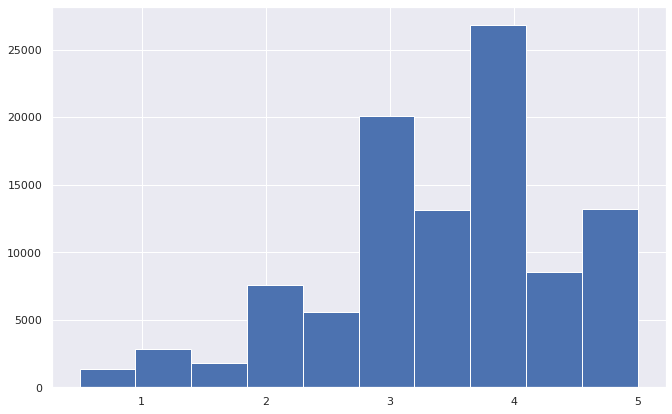

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(11,7))
plt.hist(df['rating'])
plt.show()

In [59]:
df['rating'].value_counts()

4.0    26821
3.0    20048
5.0    13215
3.5    13136
4.5     8551
2.0     7553
2.5     5550
1.0     2812
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [60]:
mae_col = abs(df['rating'] - 4)
mae = mae_col.sum()/len(df)
print('mae', mae)

mae 0.8453003064047517


In [61]:
mae_col = abs(df['rating'] - average_rating)
mae = mae_col.sum()/len(df)
print('mae', mae)

mae 0.8271467947415906


In [62]:
mse_col = (df['rating'] - average_rating)**2
mse = mse_col.sum()/len(df)
print('rmse', mse**0.5)

rmse 1.0425658715935078


## Deep Learning Model

In [63]:
# imports for deep learning
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [64]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

n_users = len(user2user_encoded)
n_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        n_users, n_movies, min_rating, max_rating
    )
)

Number of users: 611, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [65]:
df.head()

,userId,movieId,title,rating,user,movie
0,1,1,Toy Story,4.0,0,0
1,5,1,Toy Story,4.0,1,0
2,7,1,Toy Story,4.5,2,0
3,15,1,Toy Story,2.5,3,0
4,17,1,Toy Story,4.5,4,0


In [66]:
movie_dict = movie_title_id_dict(df, 'title', 'movie', display=True)

Toy Story: 0
Jumanji: 1
Grumpier Old Men: 2
Waiting to Exhale: 3
Father of the Bride Part II: 4


In [67]:
from sklearn.model_selection import train_test_split

# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(df, test_size=0.10, shuffle=True)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True)

n_users = df.userId.unique().shape[0]
print('users:', n_users)

n_movies = df.movieId.unique().shape[0]
print('movies:', n_movies)

users: 611
movies: 9724


In [68]:
# Recommender System using Matrix Factorization, keras style

n_latent_factors = 15

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1,
                           output_dim=n_latent_factors,
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1,
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_absolute_error')

In [69]:
history = model.fit(x=[X_train.user, X_train.movie],
                    y=X_train.rating, epochs=10,
                    validation_data=([X_validation.user,
                    X_validation.movie], X_validation.rating))

Epoch 1/10
2837/2837 [==============================] - 14s 5ms/step - loss: 3.3029 - val_loss: 1.5706
Epoch 2/10
2837/2837 [==============================] - 13s 5ms/step - loss: 1.3107 - val_loss: 1.0031
Epoch 3/10
2837/2837 [==============================] - 13s 5ms/step - loss: 0.8896 - val_loss: 0.8828
Epoch 4/10
2837/2837 [==============================] - 14s 5ms/step - loss: 0.7643 - val_loss: 0.8413
Epoch 5/10
2837/2837 [==============================] - 14s 5ms/step - loss: 0.7161 - val_loss: 0.8192
Epoch 6/10
2837/2837 [==============================] - 14s 5ms/step - loss: 0.6813 - val_loss: 0.8068
Epoch 7/10
2837/2837 [==============================] - 14s 5ms/step - loss: 0.6582 - val_loss: 0.8014
Epoch 8/10
2837/2837 [==============================] - 14s 5ms/step - loss: 0.6428 - val_loss: 0.7997
Epoch 9/10
2837/2837 [==============================] - 14s 5ms/step - loss: 0.6255 - val_loss: 0.7923
Epoch 10/10
2837/2837 [==============================] - 18s 6ms/step - l

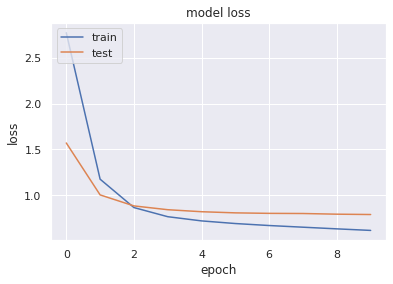

In [70]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Predictions

In [71]:
# select movie recommendations for 1 user
user_1 = df[df['userId'] == 0]
user_1.sort_values('rating', ascending=False)

,userId,movieId,title,rating,user,movie
100838,0,4896,Harry Potter and the Sorcerer's Stone,5.0,610,3569
100840,0,115713,Ex Machina,5.0,610,8532
100842,0,1270,Back to the Future,5.0,610,968
100843,0,2918,Ferris Bueller's Day Off,5.0,610,2194
100836,0,858,"Godfather, The",4.0,610,659
100844,0,1136,Monty Python and the Holy Grail,4.0,610,862
100845,0,1197,"Princess Bride, The",4.0,610,898
100841,0,1206,"Clockwork Orange, A",3.0,610,906
100837,0,2571,"Matrix, The",2.0,610,1938
100846,0,1,Toy Story,2.0,610,0


In [72]:
def prediction_movie(user_id, movie):
  # predict any movie for user 
  dim1 = np.array([user_id])
  dim2 = np.array([movie_dict[movie]])
  pred = [dim1, dim2]
  return model.predict(pred).flatten()[0]

prediction_movie(610, 'Gladiator')

3.8925343

In [73]:
def prediction_id(user_id, movie_id):
  # predict any movie for user 
  dim1 = np.array([user_id])
  dim2 = np.array([movie_id])
  pred = [dim1, dim2]
  return model.predict(pred).flatten()[0]

prediction_id(610, 1272)

3.266872

In [ ]:
user_df = df[df['user']==0]

predictions=[]
for movie, movie_id in movie_dict.items():
  if movie_id not in user_df['movie']:
    pred = prediction_id(610, movie_id)
    predictions.append([pred, movie_id, movie])
ordered_list = sorted(predictions, key=lambda x: x[0])
ordered_list.reverse()
print(ordered_list[:20])

[[5.287087, 5476, 'Holy Mountain, The'], [5.0080533, 5567, 'Bad Boy Bubby'], [4.9762926, 3184, 'Rififi'], [4.963457, 3500, 'Phantom of the Paradise'], [4.904945, 7235, 'Anne of Green Gables: The Sequel'], [4.882421, 2593, 'Jonah Who Will Be 25 in the Year 2000'], [4.797986, 5832, 'Wild Parrots of Telegraph Hill, The'], [4.7734466, 48, 'Lamerica'], [4.756078, 1663, 'Swept Away'], [4.750597, 3276, 'Game of Death'], [4.735022, 6937, 'Timecrimes'], [4.734271, 8730, 'A Pigeon Sat on a Branch Reflecting on Existence'], [4.731199, 2396, 'Titus'], [4.7053003, 5192, 'Jetée, La'], [4.676816, 9611, 'Paddington 2'], [4.6698275, 9552, 'Black Mirror: White Christmas'], [4.667601, 4384, 'Belle époque'], [4.6624136, 2645, 'What Ever Happened to Baby Jane?'], [4.659303, 3584, 'Now, Voyager'], [4.6521206, 7793, 'All Watched Over by Machines of Loving Grace']]


In [ ]:
my_movie_list = ordered_list
import csv
with open("movie_preds_BCA_summer2021.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(my_movie_list)

# keras model

In [ ]:
#df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

model = RecommenderNet(n_users, n_movies, EMBEDDING_SIZE)
model.compile(
    loss=(tf.keras.losses.MeanAbsoluteError()), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

In [ ]:
movie_df = df_movies

# Let us get a user and see the top recommendations.
user_id = 1
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)
